# Hurdel model in AdaSTEM

Yangkang Chen<br>
Jan 12, 2024

This notebook is to discuss the pros and cons of two different AdaSTEM modeling framework: `Hurdel in AdaSTEM` and `AdaSTEM in Hurdle`.

To recap the content [here](https://chenyangkang.github.io/stemflow/Tips/Tips_for_different_tasks.html) (If you don't know what is hurdle model please read this), if the task is to predict abundance, there are two ways to leverage the hurdle model. 



1. First, **hurdle in AdaSTEM**: one can use hurdle model in each AdaSTEM (regressor) stixel; 
>
>
>That is:
>
>```python
>Model_Hurdle_in_Ada = AdaSTEMRegressor(
>    base_model=Hurdle(
>        classifier=XGBClassifier(...),
>        regressor=XGBRegressor(...)
>    ),  
>    ...
>)
>```

2. Second, **AdaSTEM in hurdle**: one can use `AdaSTEMClassifier` as the classifier of the hurdle model, and `AdaSTEMRegressor` as the regressor of the hurdle model. 
>
>
>That is:
>
>```python
>model_Ada_in_Hurdle = Hurdle_for_AdaSTEM(
>    classifier=AdaSTEMClassifier(
>        base_model=XGBClassifier(...),
>        ...),
>    regressor=AdaSTEMRegressor(
>        base_model=XGBRegressor(...),
>        ...)
>)
>
>```


In the first case, the classifier and regressor "talk" to each other in each separate stixel (hereafter, "hurdle in Ada"); In the second case, the classifiers and regressors form two "unions" separately, and these two unions only "talk" to each other at the final combination, instead of in each stixel (hereafter, "Ada in hurdle"). This is a common practice in most paper I've seen, including reference [1-3].



The conclusion goes first:<br>
**We recommend users to always use Hurdle model as base model of AdaSTEMRegressor (Hurdle in Ada)**


In [2]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os

from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle
from stemflow.model_selection import ST_CV

# warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

## Download data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

## Load data

In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


In [5]:
data.head()

,longitude,latitude,count,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
0,-83.472224,8.859308,0.0,22,300.0,1,0,0,4.828,5.0,34.0,476,7.555556,0.758156,0.036083,-0.021484,24.883502,5.174890,59.628088,93.482247,30.529131,21.850519,8.678612,24.302626,26.536822,26.213334,23.864924,0.720487,0.127594,0.003156,0.001451,0.332425,0.026401,0.044218,0.260672,0.0,0.000000,0.0,0.0,0.0,0.138889,0.000000,0.000000,0.000000,0.0,0.0,0.777778,0.000000,0.000000,0.083333,0.000000,0.676720
1,-2.687724,43.373323,9.0,290,90.0,1,0,0,0.570,2.0,151.0,1075,30.833336,3.376527,0.050544,-0.099299,14.107917,5.224109,31.174167,376.543853,23.219421,6.461607,16.757814,9.048385,19.092725,19.236082,9.287841,0.171423,0.035598,0.004512,0.000081,0.084657,0.018400,0.030210,0.065007,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.194444,0.027778,0.000000,0.361111,1.359063
2,-89.884770,35.087255,0.0,141,10.0,0,1,0,-1.000,2.0,678.0,575,91.777780,0.558100,-0.187924,-0.269078,17.396487,8.673912,28.688889,718.996078,32.948335,2.713938,30.234397,14.741099,13.759220,26.795849,7.747272,0.187089,0.031802,0.005878,0.000044,0.073328,0.026618,0.039616,0.059673,0.0,0.055556,0.0,0.0,0.0,0.000000,0.000000,0.305556,0.000000,0.0,0.0,0.000000,0.527778,0.000000,0.000000,0.111111,1.104278
3,-99.216873,31.218510,0.0,104,9.0,1,0,0,0.805,2.0,976.0,657,553.166700,0.856235,-0.347514,-0.342971,20.740836,10.665164,35.409121,666.796919,35.909941,5.790119,30.119822,18.444353,30.734456,29.546417,11.701038,0.084375,0.025289,0.000791,0.000052,0.052866,0.004096,0.006064,0.015965,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
4,-124.426730,43.065847,2.0,96,30.0,1,0,0,0.161,2.0,654.0,600,6.500000,0.491816,-0.347794,-0.007017,11.822340,6.766870,35.672897,396.157833,22.608788,3.639569,18.969219,8.184412,16.290802,17.258721,7.319234,0.144122,0.044062,0.000211,0.000147,0.089238,0.004435,0.004822,0.040621,0.0,0.000000,0.0,0.0,0.0,0.361111,0.166667,0.000000,0.472222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.020754


## Get X and y

In [5]:
X = data.drop('count', axis=1)
y = data['count'].values


## First thing first: Spatio-temporal train test split

In [6]:
CV = 5
CV_generator = ST_CV(X, y, 
                    Spatio_blocks_count = 50, Temporal_blocks_count=50,
                    random_state=42, CV=CV)

For more discussion on parameters please see [AdaSTEM demo](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html).

## Train Hurdle in AdaSTEM

Now, we use the recommended model structure: Hurdle model as base model of AdaSTEM framework:

In [8]:
model_hurdle_in_Ada = AdaSTEMRegressor(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),
    save_gridding_plot = True,
    ensemble_fold=10, 
    min_ensemble_required=7,
    grid_len_upper_threshold=25,
    grid_len_lower_threshold=5,
    points_lower_threshold=50,
    Spatio1='longitude',
    Spatio2 = 'latitude', 
    Temporal1 = 'DOY',
    use_temporal_to_train=True,
    njobs=4                       
)



For more discussion on parameters please see [AdaSTEM demo](https://chenyangkang.github.io/stemflow/Examples/01.AdaSTEM_demo.html) and [Optimizing stixel size](https://chenyangkang.github.io/stemflow/Examples/07.Optimizing_stixel_size.html). 


We train and evaluate the model for each CV partition, and plot the charts:

  0%|          | 0/5 [00:00<?, ?it/s]

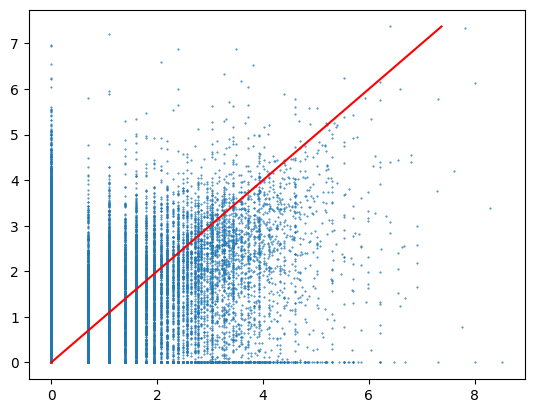

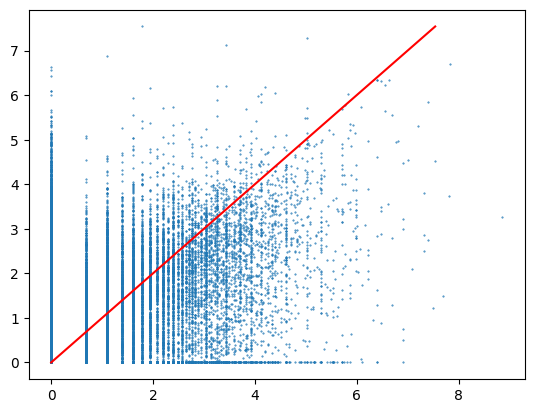

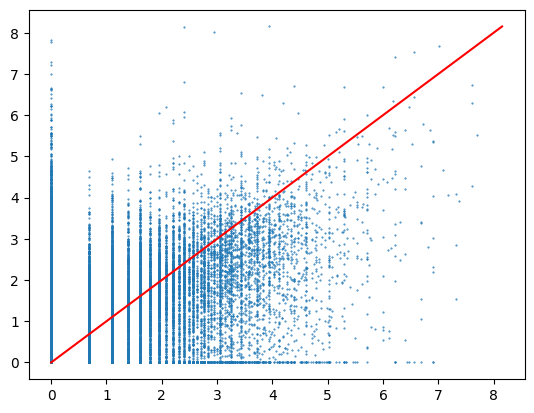

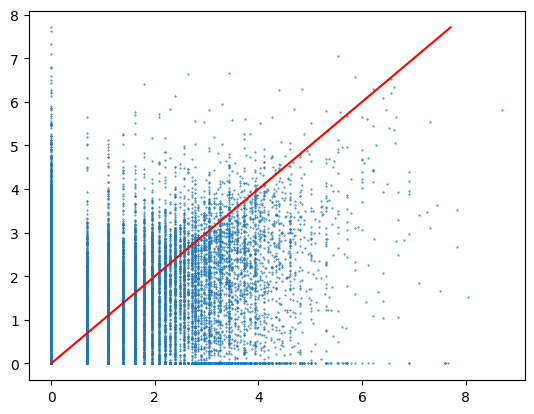

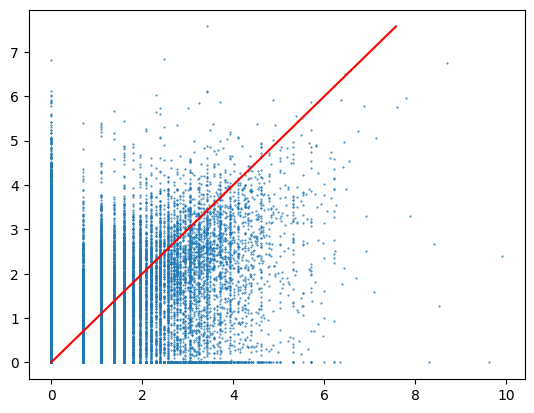

In [9]:
metric_dict_list = []
for X_train, X_test, y_train, y_test in tqdm(CV_generator, total=CV):
    ## fit model
    model_hurdle_in_Ada.fit(X_train, y_train, verbosity=0)
    ## predict on test set
    pred_hurdle_in_Ada = model_hurdle_in_Ada.predict(X_test, verbosity=0)
    pred_hurdle_in_Ada = np.where(pred_hurdle_in_Ada<0, 0, pred_hurdle_in_Ada)
    ## calculate metrics
    metrics_hurdle_in_Ada= AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), pred_hurdle_in_Ada.flatten())
    metric_dict_list.append(metrics_hurdle_in_Ada)
    
    # plot
    a = pd.DataFrame({
        'y_true':y_test.flatten(),
        'y_pred':pred_hurdle_in_Ada.flatten()
    }).dropna()
    plt.scatter(np.log(a.y_true+1), np.log(a.y_pred+1), s=0.2)
    plt.plot([0,np.log(a.y_pred+1).max()],[0,np.log(a.y_pred+1).max()], c='red')
    plt.show()
    

Save the metrics for later plotting:

In [10]:
hurdle_in_Ada_metrics = pd.DataFrame(metric_dict_list)
hurdle_in_Ada_metrics


,AUC,kappa,f1,precision,recall,average_precision,Spearman_r,Pearson_r,R2,MAE,MSE,poisson_deviance_explained
0,0.776556,0.399602,0.533535,0.402644,0.790514,0.353562,0.486733,0.228122,0.004291,4.060732,1547.538014,0.163586
1,0.763234,0.378516,0.519680,0.390772,0.775506,0.341389,0.466746,0.200849,-0.006095,4.367535,1690.584790,0.166015
2,0.766110,0.384527,0.528265,0.397766,0.786202,0.350321,0.476049,0.212550,-0.686252,4.488267,1561.115758,0.188853
3,0.766000,0.386848,0.525204,0.397605,0.773404,0.346218,0.469835,0.158039,-0.091035,4.305906,1755.312096,0.173555
4,0.766309,0.381845,0.526306,0.394553,0.790164,0.348524,0.474678,0.107553,0.010033,4.417231,9685.441546,0.161657


In [11]:
hurdle_in_Ada_metrics.to_csv('./hurdle_in_Ada_metrics.csv', index=False)

## Train AdaSTEM in Hurdle

Likewise, we also train models that using AdaSTEM as regressor and classifier for a single hurdle model:

In [8]:
model_Ada_in_Hurdle = Hurdle_for_AdaSTEM(
    classifier=AdaSTEMClassifier(base_model=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_upper_threshold=25,
                                grid_len_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True,
                                njobs=4),
    regressor=AdaSTEMRegressor(base_model=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_upper_threshold=25,
                                grid_len_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True,
                                njobs=4)
)





The evaluation is also conducted for each CV partition:

  0%|          | 0/5 [00:00<?, ?it/s]

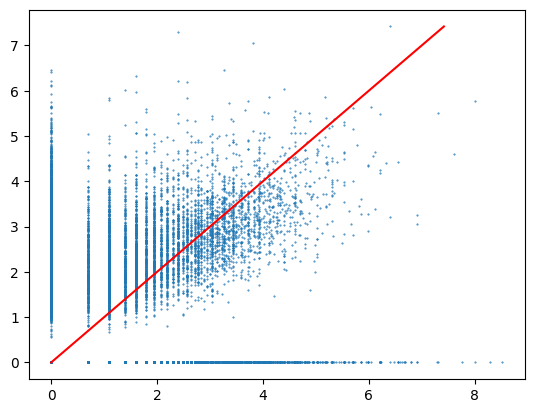

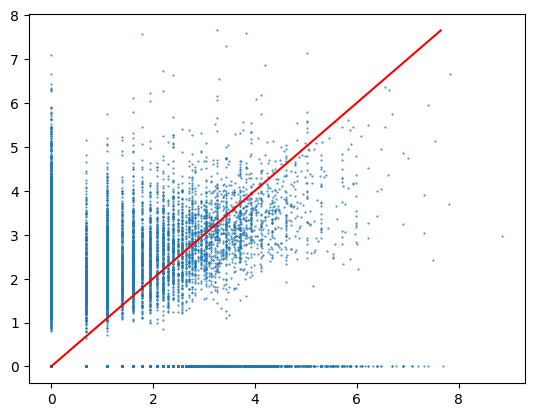

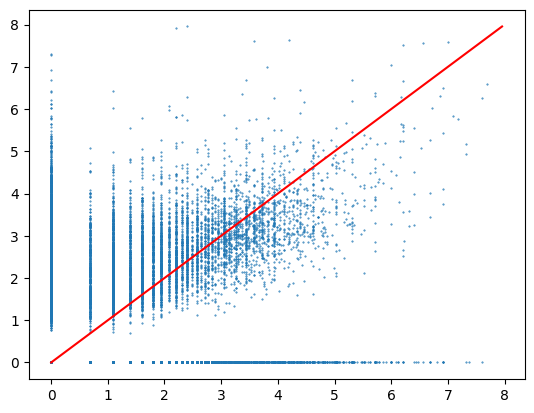

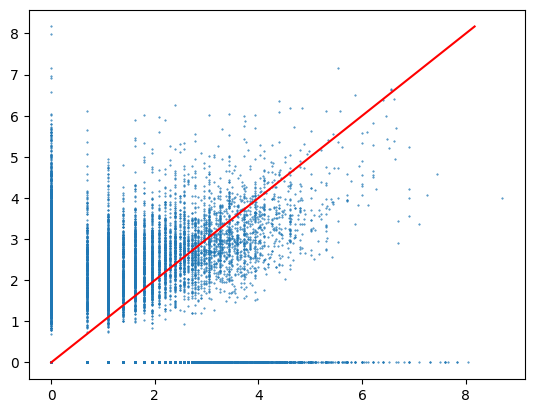

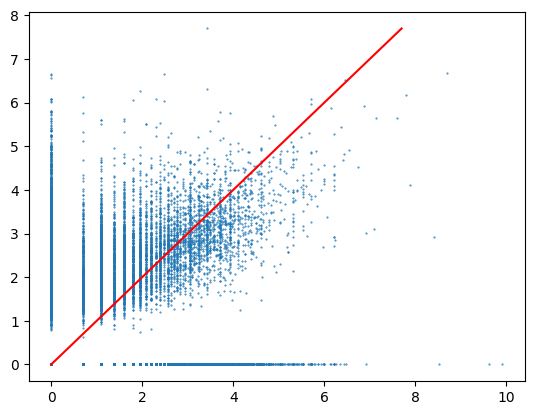

In [10]:
CV_generator = ST_CV(X, y, 
                    Spatio_blocks_count = 50, Temporal_blocks_count=50,
                    random_state=42, CV=CV)


metric_dict_list = []
for X_train, X_test, y_train, y_test in tqdm(CV_generator, total=CV):
    ## fit model
    model_Ada_in_Hurdle.fit(X_train, y_train, verbosity=0)
    ## predict on test set
    pred_Ada_in_Hurdle = model_Ada_in_Hurdle.predict(X_test, verbosity=0)
    pred_Ada_in_Hurdle = np.where(pred_Ada_in_Hurdle<0, 0, pred_Ada_in_Hurdle)
    
    ## calculate metrics
    metrics_Ada_in_Hurdle= AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), pred_Ada_in_Hurdle.flatten())
    metric_dict_list.append(metrics_Ada_in_Hurdle)
    
    # plot
    a = pd.DataFrame({
        'y_true':y_test.flatten(),
        'y_pred':pred_Ada_in_Hurdle.flatten()
    }).dropna()
    plt.scatter(np.log(a.y_true+1), np.log(a.y_pred+1), s=0.2)
    plt.plot([0,np.log(a.y_pred+1).max()],[0,np.log(a.y_pred+1).max()], c='red')
    plt.show()
    
    

In [11]:
Ada_in_hurdle_metrics = pd.DataFrame(metric_dict_list)
Ada_in_hurdle_metrics


,AUC,kappa,f1,precision,recall,average_precision,Spearman_r,Pearson_r,R2,MAE,MSE,poisson_deviance_explained
0,0.697080,0.441068,0.519759,0.613785,0.450714,0.367964,0.458361,0.141498,-0.061558,3.993602,1541.766283,0.142712
1,0.680297,0.412394,0.493349,0.607135,0.415482,0.351356,0.432512,0.138424,-0.138857,4.550810,1919.024133,0.121617
2,0.690239,0.426277,0.510518,0.606079,0.440988,0.364719,0.444202,0.266970,-0.431011,4.352729,1226.860455,0.228450
3,0.684105,0.418367,0.499448,0.607101,0.424224,0.355112,0.435636,0.114824,-0.209990,4.320640,1940.877595,0.157750
4,0.688389,0.424938,0.507825,0.609872,0.435032,0.363110,0.444321,0.097006,0.004345,4.393659,9567.505443,0.252556


In [12]:
Ada_in_hurdle_metrics.to_csv('./Ada_in_hurdle_metrics.csv', index=False)

## Compare the two model structures

We have collected evaluation metrics for both `Hurdle in Ada` and `Ada in Hurdle` framework. We will now plot them:

In [13]:
hurdle_in_Ada_metrics = pd.read_csv('./hurdle_in_Ada_metrics.csv')
Ada_in_hurdle_metrics = pd.read_csv('./Ada_in_hurdle_metrics.csv')


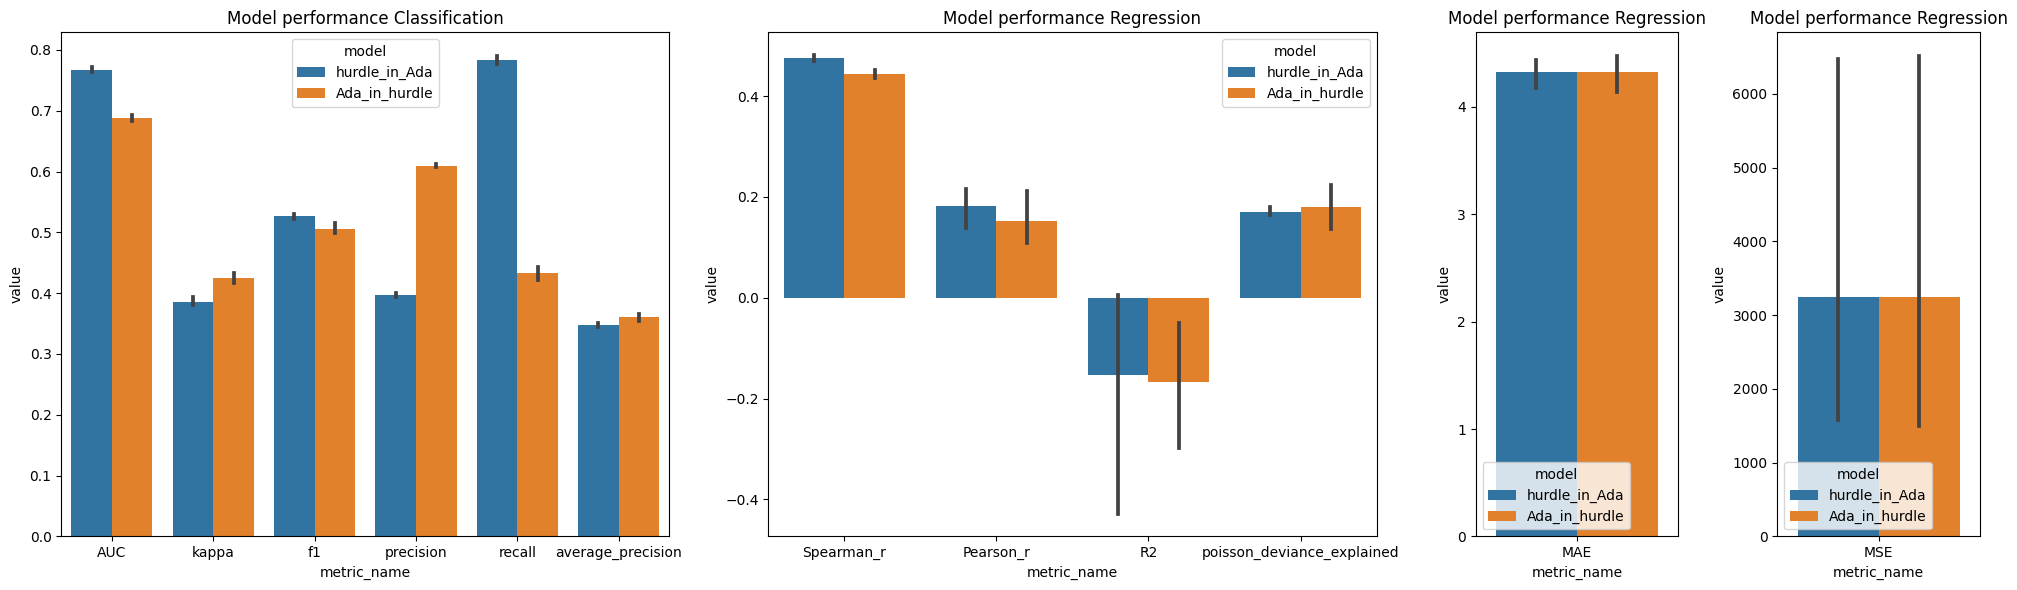

In [49]:
import seaborn as sns
hurdle_in_Ada_metrics['model'] = 'hurdle_in_Ada'
Ada_in_hurdle_metrics['model'] = 'Ada_in_hurdle'
new_dat = pd.concat([hurdle_in_Ada_metrics, Ada_in_hurdle_metrics], axis=0)
dat_for_plot = []
for index,row in new_dat.iterrows():
    for metric_name in ['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision',
                        'Spearman_r', 'Pearson_r', 'R2', 'MAE', 'MSE', 'poisson_deviance_explained']:
        dat_for_plot.append({
            'model':row['model'],
            'metric_name':metric_name,
            'value':row[metric_name]
        })
        
dat_for_plot = pd.DataFrame(dat_for_plot)

# plot
fig, ax = plt.subplots(1, 4, figsize=(20,6), gridspec_kw={'width_ratios': [3, 3, 1, 1]})

### classification
plt.sca(ax[0])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Classification')

## reg
plt.sca(ax[1])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['Spearman_r', 'Pearson_r', 'R2', 'poisson_deviance_explained'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')

## reg
plt.sca(ax[2])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['MAE'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')


## reg
plt.sca(ax[3])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['MSE'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')
# plt.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()



We show that:

1. For classification, `"Hurdle in Ada"` (the one in Johnston, 2015) shows better performance than `"Ada in Hurdle"` in terms of AUC, F1, and recall, while worse in kappa, precision, and average precision. This shold indicate that hurdle in ada is the choice if you care about occurence in SDM. Recall is more important than precision for the nature of species distribution modeling is to find suitable habitat, and for the fact that imperfect detections are common in observational data.

2. For regression (actually measuring a combination of regression and classification), there is no significant differences for these two modeling methods, except for that `"Hurdle in Ada"` shows higher spearman's r value.

**Inconclusion, `using hurdle model as AdaSTEM base model` should be the choice for abundance modeling.**


In [50]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2023-09-19T13:28:59.670936+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 0.0.24
numpy       : 1.24.3
scipy       : 1.10.1
pandas      : 2.0.3
xgboost     : 1.7.6
tqdm        : 4.65.0
matplotlib  : 3.7.1
h3pandas    : 0.2.4
geopandas   : 0.11.1
scikit-learn: 0.0



References:

1. [Fink, D., Damoulas, T., & Dave, J. (2013, June). Adaptive Spatio-Temporal Exploratory Models: Hemisphere-wide species distributions from massively crowdsourced eBird data. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 27, No. 1, pp. 1284-1290).](https://ojs.aaai.org/index.php/AAAI/article/view/8484)

1. [Fink, D., Auer, T., Johnston, A., Ruiz‐Gutierrez, V., Hochachka, W. M., & Kelling, S. (2020). Modeling avian full annual cycle distribution and population trends with citizen science data. Ecological Applications, 30(3), e02056.](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1002/eap.2056)

1. [Johnston, A., Fink, D., Reynolds, M. D., Hochachka, W. M., Sullivan, B. L., Bruns, N. E., ... & Kelling, S. (2015). Abundance models improve spatial and temporal prioritization of conservation resources. Ecological Applications, 25(7), 1749-1756.](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/14-1826.1)
